<a href="https://colab.research.google.com/github/heriswaya/MLT-Project-1-and-2/blob/main/rekomendasi_barang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [127]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## **Data Understanding**

In [8]:
# Unduh file zip dari GitHub
!wget https://github.com/heriswaya/MLT-Project-1-and-2/raw/main/dataset_recommendation/archive.zip

--2025-06-01 03:40:12--  https://github.com/heriswaya/MLT-Project-1-and-2/raw/main/dataset_recommendation/archive.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/heriswaya/MLT-Project-1-and-2/main/dataset_recommendation/archive.zip [following]
--2025-06-01 03:40:13--  https://raw.githubusercontent.com/heriswaya/MLT-Project-1-and-2/main/dataset_recommendation/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6957675 (6.6M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]   6.63M  --.-KB/s    in 0.09s   

2025-06-01 03:40:13 (73.6 MB/s) - ‘ar

In [9]:
# Ekstrak file zip
!unzip archive.zip

Archive:  archive.zip
  inflating: campaigns.csv           
  inflating: customer_reviews_complete.csv  
  inflating: customers.csv           
  inflating: interactions.csv        
  inflating: support_tickets.csv     
  inflating: transactions.csv        


Terdapat 6 file csv. <br>
Untuk membangun model Collaborative Filtering, hanya perlu menggunakan file-file yang mengandung interaksi eksplisit atau implisit antara user dan item. Berikut file yang akan digunakan:
Untuk membangun model **Collaborative Filtering**, Anda hanya perlu menggunakan file-file yang mengandung **interaksi eksplisit atau implisit antara user dan item**. Berikut rekomendasi file yang akan digunakan:
1. **`transactions.csv`**  
   - **Alasan**: Ini adalah data transaksi aktual yang menunjukkan pembelian produk oleh pelanggan.
   - **Kolom Penting**:
     - `customer_id` (User)
     - `product_name` (Item)
     - `quantity` (Implicit rating: bisa dianggap sebagai "strength of interaction")
     - `price` (Opsional: bisa digunakan untuk weighting)

2. **`customer_reviews_complete.csv`**  
   - **Alasan**: Berisi rating eksplisit (1-5) dari pelanggan.
   - **Kolom Penting**:
     - `customer_id` (User)
     - `product_name` (Item)
     - `rating` (Explicit rating)

3. **`interactions.csv`** (Opsional)  
   - **Alasan**: Bisa digunakan sebagai implicit feedback tambahan.
   - **Kolom Penting**:
     - `customer_id` (User)
     - `page_or_product` (Item)
     - `interaction_type` (e.g., "View Product" = 1 point, "Add to Cart" = 2 points, dll.)

### File yang Tidak Perlu Digunakan:
- `customers.csv` (Data demografi - lebih cocok untuk content-based, bukan collaborative)
- `campaigns.csv` (Info marketing - tidak relevan)
- `support_tickets.csv` (Data support - tidak relevan)

In [77]:
# Membaca data-data yang relevan untuk collaborative filtering
transactions = pd.read_csv('/content/transactions.csv')
reviews = pd.read_csv('/content/customer_reviews_complete.csv')
interactions = pd.read_csv('/content/interactions.csv')
customers = pd.read_csv('/content/customers.csv')  # Untuk referensi saja

In [78]:
transactions.head()

,transaction_id,customer_id,product_name,product_category,quantity,price,transaction_date,store_location,payment_method,discount_applied
0,53e3d9f5-6231-46de-aa39-e5f8eaae2eee,727839b2-f084-4e94-94d8-ae59cc8e4b84,Ring Doorbell,Smart Home Devices,1.0,140.07,2020-12-06,"Houston, TX",Credit Card,20.0
1,ae6e6edf-f2fe-45c8-989c-c01e77eade0c,c4ac244c-989e-46fb-b243-91dd1d5cf739,Oculus Quest,Gaming Consoles,1.0,339.57,2021-04-26,Online,Gift Card,0.0
2,ba85240a-2b5d-4987-ac0a-efb6a4a57d6d,d296bf0d-92bb-4670-a578-2fd3553cf7c8,Samsung Galaxy S22,Smartphones,2.0,1335.88,2021-10-28,Online,PayPal,30.0
3,3725a285-2a2b-4a80-b317-7c8041cd9b8b,7b1b9980-9d65-40fc-8ad6-6afaae4699e4,External Hard Drive,Computer Accessories,1.0,91.56,2023-03-16,Online,Credit Card,25.0
4,de1b05a5-68c7-4b00-a068-e8c2f13f0dab,8595dcfa-2bfc-46f4-a15a-042af85b78cd,MacBook Pro,Laptops,1.0,985.15,2022-08-30,"Atlanta, GA",Credit Card,0.0


In [79]:
reviews.head()

,review_id,customer_id,product_name,product_category,full_name,transaction_date,review_date,rating,review_title,review_text
0,rev_000001,e9848049-323f-4f95-a26e-3cffc219d591,Bookshelf,Furniture,Patrick Guerrero,2024-05-30,2024-06-12,5,Sturdy and Elegant Addition to My Study Room,Just received the bookshelf I've been eyeing f...
1,rev_000002,24bcc3c6-ce17-423f-87f5-a1f6d1114ba7,Oculus Quest,Gaming Consoles,Katie Burton,2024-03-10,2024-04-05,5,Immersive Virtual Reality Adventure!,"Katie Burton, a tech enthusiast from Dallas, T..."
2,rev_000003,8806399f-1c9b-47f7-b8ca-fac5468438ff,OnePlus 10,Smartphones,Fernando Rogers,2024-06-14,2024-06-29,4,"Impressive Performance, Room for Improvement i...",The OnePlus 10 has been a great addition to my...
3,rev_000004,62ab496d-f69a-48af-b44c-08ac79b6f68d,iPhone 13,Smartphones,Sara Howell,2024-03-27,2024-04-06,4,"Solid Upgrade, Could've Been Perfect!",The iPhone 13 has been a great addition to my ...
4,rev_000005,1b7daed4-aaa6-41b1-9826-0d51d67614e3,Bookshelf,Furniture,Kelly Kim,2023-08-16,2023-09-01,4,"Sturdy, Yet Lacking Personality",I recently purchased this bookshelf for my hom...


In [80]:
interactions.head()

,interaction_id,customer_id,channel,interaction_type,interaction_date,duration,page_or_product,session_id
0,423db3d3-659d-433f-859a-eea2ff1e2d2c,00012aa8-e99c-4e30-b3f6-1f7e36adc517,NaN,review,2023-03-11 08:37:00,128.0,home,00012aa8-e99c-4e30-b3f6-1f7e36adc517_session_0
1,8cf67dd6-63f8-4333-924d-2126aa87a91d,00012aa8-e99c-4e30-b3f6-1f7e36adc517,web,wishlist_add,2023-03-22 04:57:00,9.0,Dell XPS 15,00012aa8-e99c-4e30-b3f6-1f7e36adc517_session_1
2,2e8e17c8-c40f-46ea-810f-08c987eb07c7,00012aa8-e99c-4e30-b3f6-1f7e36adc517,web,review,2023-04-11 14:47:00,205.0,category_kitchen,00012aa8-e99c-4e30-b3f6-1f7e36adc517_session_2
3,d5d18036-735c-4d70-842a-0f82a4873fbf,00012aa8-e99c-4e30-b3f6-1f7e36adc517,web,page_view,2023-05-23 07:20:00,65.0,category_laptops,00012aa8-e99c-4e30-b3f6-1f7e36adc517_session_3
4,ef756343-1635-4510-85c8-41a399adb8f8,00012aa8-e99c-4e30-b3f6-1f7e36adc517,web,product_view,2023-06-06 02:57:00,146.0,Bose Headphones,00012aa8-e99c-4e30-b3f6-1f7e36adc517_session_4


In [81]:
customers.head()

,customer_id,full_name,age,gender,email,phone,street_address,city,state,zip_code,registration_date,preferred_channel
0,4c30e132-0704-4459-a509-9eddde934977,Mark Johnson,40.0,Male,mark.johnson@yahoo.com,989.608.3863,819 Johnson Course,Houston,Texas,29158.0,2024-04-25,NaN
1,68bec407-275f-4b5b-9a82-13d02f54626a,Robert Smith,33.0,Male,smithr@yahoo.com,(518)349-5931x0341,35116 Michael Key Suite 078,Austin,Texas,16862.0,2021-05-30,in-store
2,4466459f-76c8-433c-814e-6d59cb4131fc,Jamie Chavez,42.0,Female,jchavez@gmail.com,364.583.5030x564,419 Amanda Gardens,Detroit,Michigan,21918.0,2023-12-14,online
3,04c36a25-02f3-462c-92b0-6bf291c57706,Thomas Bradley,53.0,Male,thomas.bradley@hotmail.com,(332)887-1012x269,7242 Julie Plain Suite 969,Fort Worth,Texas,52851.0,2022-07-11,both
4,e916df3d-c3f5-40b0-8ae2-5d043be88300,Jane Ferrell,32.0,Female,jane.ferrell@hotmail.com,5484281489,845 Kelly Estate,Atlanta,Georgia,59971.0,2020-09-06,online


In [82]:
print('Jumlah data pelanggan unik: ', len(customers.customer_id.unique()))
print('Jumlah produk unik yang dibeli: ', len(transactions.product_name.unique()))
print('Jumlah transaksi: ', len(transactions))
print('Jumlah rating/review: ', len(reviews))
print('Jumlah interaksi pengguna: ', len(interactions))

print('\n=== DETAIL INTERAKSI ===')
print('Jumlah pelanggan yang memberikan rating: ', len(reviews.customer_id.unique()))
print('Jumlah produk yang mendapat rating: ', len(reviews.product_name.unique()))
print('Jumlah pelanggan yang berinteraksi: ', len(interactions.customer_id.unique()))
print('Jumlah produk yang diinteraksi: ', len(interactions.page_or_product.unique()))

print('\n=== DISTRIBUSI RATING ===')
print(reviews.rating.value_counts().sort_index())

Jumlah data pelanggan unik:  5000
Jumlah produk unik yang dibeli:  76
Jumlah transaksi:  32295
Jumlah rating/review:  1000
Jumlah interaksi pengguna:  100000

=== DETAIL INTERAKSI ===
Jumlah pelanggan yang memberikan rating:  830
Jumlah produk yang mendapat rating:  75
Jumlah pelanggan yang berinteraksi:  4994
Jumlah produk yang diinteraksi:  35

=== DISTRIBUSI RATING ===
rating
1     30
2     76
3    142
4    350
5    402
Name: count, dtype: int64


## **Univariate Exploratory Data Analysis**

Penjelasan nama variabel yang digunakan:
- transactions: Data transaksi pembelian produk oleh pelanggan
- reviews: Data rating dan review produk oleh pelanggan
- interactions: Data interaksi pengguna dengan produk (view, click, dll)
- customers: Data profil pelanggan (digunakan hanya untuk referensi)

### Transactions

In [83]:
print("📦 EDA: Transactions")
transactions.info()

📦 EDA: Transactions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32295 entries, 0 to 32294
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    32295 non-null  object 
 1   customer_id       32295 non-null  object 
 2   product_name      31617 non-null  object 
 3   product_category  31609 non-null  object 
 4   quantity          31651 non-null  float64
 5   price             31673 non-null  float64
 6   transaction_date  32295 non-null  object 
 7   store_location    31651 non-null  object 
 8   payment_method    31635 non-null  object 
 9   discount_applied  31684 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.5+ MB


In [84]:
print("\nJumlah transaksi:", transactions.shape[0])
print("Jumlah customer unik:", transactions['customer_id'].nunique())
print("Jumlah produk unik:", transactions['product_name'].nunique())
print("Jumlah kategori produk unik:", transactions['product_category'].nunique())

print("\nMetode pembayaran yang digunakan:", transactions['payment_method'].unique())
print("Jumlah metode pembayaran unik:", transactions['payment_method'].nunique())

print("\nCek data kosong:")
print(transactions.isnull().sum())

print("\nStatistik deskriptif kolom numerik:")
print(transactions[['quantity', 'price', 'discount_applied']].describe())


Jumlah transaksi: 32295
Jumlah customer unik: 4618
Jumlah produk unik: 75
Jumlah kategori produk unik: 15

Metode pembayaran yang digunakan: ['Credit Card' 'Gift Card' 'PayPal' 'Debit Card' 'Apple Pay' 'Cash' nan
 'Google Pay']
Jumlah metode pembayaran unik: 7

Cek data kosong:
transaction_id        0
customer_id           0
product_name        678
product_category    686
quantity            644
price               622
transaction_date      0
store_location      644
payment_method      660
discount_applied    611
dtype: int64

Statistik deskriptif kolom numerik:
           quantity         price  discount_applied
count  31651.000000  31673.000000      31684.000000
mean       1.438564    622.471618          5.255018
std        2.160827    664.649715          9.280936
min        1.000000     17.450000          0.000000
25%        1.000000    179.690000          0.000000
50%        1.000000    401.700000          0.000000
75%        2.000000    876.560000         10.000000
max       50.0

### Reviews

In [85]:
print("📝 EDA: Reviews")
reviews.info()

📝 EDA: Reviews
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         1000 non-null   object
 1   customer_id       1000 non-null   object
 2   product_name      976 non-null    object
 3   product_category  981 non-null    object
 4   full_name         981 non-null    object
 5   transaction_date  1000 non-null   object
 6   review_date       1000 non-null   object
 7   rating            1000 non-null   int64 
 8   review_title      1000 non-null   object
 9   review_text       1000 non-null   object
dtypes: int64(1), object(9)
memory usage: 78.3+ KB


In [86]:
print("\nJumlah review:", reviews.shape[0])
print("Jumlah customer unik:", reviews['customer_id'].nunique())
print("Jumlah produk unik:", reviews['product_name'].nunique())
print("Jumlah kategori produk unik:", reviews['product_category'].nunique())

print("\nStatistik rating:")
print(reviews['rating'].describe())

print("\nDistribusi rating:")
print(reviews['rating'].value_counts().sort_index())

print("\nCek data kosong:")
print(reviews.isnull().sum())


Jumlah review: 1000
Jumlah customer unik: 830
Jumlah produk unik: 74
Jumlah kategori produk unik: 15

Statistik rating:
count    1000.000000
mean        4.018000
std         1.057731
min         1.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

Distribusi rating:
rating
1     30
2     76
3    142
4    350
5    402
Name: count, dtype: int64

Cek data kosong:
review_id            0
customer_id          0
product_name        24
product_category    19
full_name           19
transaction_date     0
review_date          0
rating               0
review_title         0
review_text          0
dtype: int64


### Interactions

In [87]:
print("🖱️ EDA: Interactions")
interactions.info()

🖱️ EDA: Interactions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   interaction_id    100000 non-null  object 
 1   customer_id       100000 non-null  object 
 2   channel           97998 non-null   object 
 3   interaction_type  97978 non-null   object 
 4   interaction_date  100000 non-null  object 
 5   duration          98037 non-null   float64
 6   page_or_product   98073 non-null   object 
 7   session_id        100000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


In [88]:
print("\nJumlah interaksi:", interactions.shape[0])
print("Jumlah customer unik:", interactions['customer_id'].nunique())
print("Jumlah jenis interaksi unik:", interactions['interaction_type'].nunique())
print("Jumlah channel unik:", interactions['channel'].nunique())

print("\nJenis interaksi yang tersedia:")
print(interactions['interaction_type'].value_counts())

print("\nCek data kosong:")
print(interactions.isnull().sum())

print("\nStatistik durasi interaksi:")
print(interactions['duration'].describe())


Jumlah interaksi: 100000
Jumlah customer unik: 4994
Jumlah jenis interaksi unik: 14
Jumlah channel unik: 3

Jenis interaksi yang tersedia:
interaction_type
checkout              13214
product_view          12688
search                10421
wishlist_add          10399
add_to_cart           10269
purchase              10255
page_view              6977
review                 6930
notification_click     3394
app_open               3354
inventory_check        2754
session_start          2517
store_map_view         2417
product_lookup         2389
Name: count, dtype: int64

Cek data kosong:
interaction_id         0
customer_id            0
channel             2002
interaction_type    2022
interaction_date       0
duration            1963
page_or_product     1927
session_id             0
dtype: int64

Statistik durasi interaksi:
count    98037.000000
mean        81.237227
std         84.701625
min          1.000000
25%          8.000000
50%         50.000000
75%        134.000000
max        

### Customers

In [89]:
print("👤 EDA: Customers")
customers.info()

👤 EDA: Customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        5000 non-null   object 
 1   full_name          4894 non-null   object 
 2   age                4814 non-null   float64
 3   gender             4888 non-null   object 
 4   email              4889 non-null   object 
 5   phone              4814 non-null   object 
 6   street_address     4823 non-null   object 
 7   city               4903 non-null   object 
 8   state              4907 non-null   object 
 9   zip_code           4904 non-null   float64
 10  registration_date  5000 non-null   object 
 11  preferred_channel  4886 non-null   object 
dtypes: float64(2), object(10)
memory usage: 468.9+ KB


In [90]:
print("\nJumlah customer:", customers.shape[0])
print("Jumlah gender unik:", customers['gender'].nunique())
print("Jumlah kota unik:", customers['city'].nunique())
print("Jumlah channel pilihan unik:", customers['preferred_channel'].nunique())

print("\nDistribusi gender:")
print(customers['gender'].value_counts())

print("\nCek data kosong:")
print(customers.isnull().sum())

print("\nStatistik umur:")
print(customers['age'].describe())


Jumlah customer: 5000
Jumlah gender unik: 4
Jumlah kota unik: 74
Jumlah channel pilihan unik: 3

Distribusi gender:
gender
Female               2413
Male                 2297
Non-binary            125
Prefer not to say      53
Name: count, dtype: int64

Cek data kosong:
customer_id            0
full_name            106
age                  186
gender               112
email                111
phone                186
street_address       177
city                  97
state                 93
zip_code              96
registration_date      0
preferred_channel    114
dtype: int64

Statistik umur:
count    4814.000000
mean       35.039676
std        11.084544
min        18.000000
25%        27.000000
50%        35.000000
75%        42.000000
max        80.000000
Name: age, dtype: float64


## **Data Preprocessing**
Mengambil kolom-kolom penting dari tiap dataframe, lalu menggabungkan atau menyusun ulang data sehingga siap dibersihkan (di tahap berikutnya).

### Menggabungkan seluruh user–item–rating

In [91]:
# Data utama: customer_id, product_name, rating
ratings_df = reviews[['customer_id', 'product_name', 'rating']].dropna()

print("Jumlah total interaksi rating:", ratings_df.shape[0])
print("Jumlah user unik:", ratings_df['customer_id'].nunique())
print("Jumlah produk unik:", ratings_df['product_name'].nunique())
ratings_df.head()

Jumlah total interaksi rating: 976
Jumlah user unik: 814
Jumlah produk unik: 74


,customer_id,product_name,rating
0,e9848049-323f-4f95-a26e-3cffc219d591,Bookshelf,5
1,24bcc3c6-ce17-423f-87f5-a1f6d1114ba7,Oculus Quest,5
2,8806399f-1c9b-47f7-b8ca-fac5468438ff,OnePlus 10,4
3,62ab496d-f69a-48af-b44c-08ac79b6f68d,iPhone 13,4
4,1b7daed4-aaa6-41b1-9826-0d51d67614e3,Bookshelf,4


### Menggabungkan data produk

In [92]:
# Ambil data unik produk dari transactions
product_features = transactions[['product_name', 'product_category']].dropna().drop_duplicates()

# Gabungkan dengan data rating
ratings_df = ratings_df.merge(product_features, on='product_name', how='left')

ratings_df.head()

,customer_id,product_name,rating,product_category
0,e9848049-323f-4f95-a26e-3cffc219d591,Bookshelf,5,Furniture
1,24bcc3c6-ce17-423f-87f5-a1f6d1114ba7,Oculus Quest,5,Gaming Consoles
2,8806399f-1c9b-47f7-b8ca-fac5468438ff,OnePlus 10,4,Smartphones
3,62ab496d-f69a-48af-b44c-08ac79b6f68d,iPhone 13,4,Smartphones
4,1b7daed4-aaa6-41b1-9826-0d51d67614e3,Bookshelf,4,Furniture


### Mengetahui jumlah rating per user dan per produk

In [93]:
# Rating per user
rating_per_user = ratings_df.groupby('customer_id').size().sort_values(ascending=False)
print("5 user dengan jumlah rating terbanyak:")
print(rating_per_user.head())

# Rating per produk
rating_per_product = ratings_df.groupby('product_name').size().sort_values(ascending=False)
print("\n5 produk dengan jumlah rating terbanyak:")
print(rating_per_product.head())

5 user dengan jumlah rating terbanyak:
customer_id
4b0280bd-65d5-454c-9a06-51855ae3509d    4
120d232b-79a5-4c29-a4f1-ea5dd79ddfa0    3
79177170-a532-4925-9860-078e6ec7ff5b    3
483977d6-59a3-4d37-acfe-4ae889bad936    3
0d81ab41-dba9-42d2-95c5-9ea4863dda01    3
dtype: int64

5 produk dengan jumlah rating terbanyak:
product_name
iPhone 13           38
Google Pixel 6      35
Smart Thermostat    32
Electric Range      31
Table Lamp          27
dtype: int64


### Gabung nama pelanggan atau info lain (hanya untuk referensi UI / analisis)

In [94]:
# Tambahkan nama lengkap user dari reviews
user_names = reviews[['customer_id', 'full_name']].drop_duplicates()

# Gabungkan ke data rating
ratings_df = ratings_df.merge(user_names, on='customer_id', how='left')
ratings_df

,customer_id,product_name,rating,product_category,full_name
0,e9848049-323f-4f95-a26e-3cffc219d591,Bookshelf,5,Furniture,Patrick Guerrero
1,24bcc3c6-ce17-423f-87f5-a1f6d1114ba7,Oculus Quest,5,Gaming Consoles,Katie Burton
2,8806399f-1c9b-47f7-b8ca-fac5468438ff,OnePlus 10,4,Smartphones,Fernando Rogers
3,62ab496d-f69a-48af-b44c-08ac79b6f68d,iPhone 13,4,Smartphones,Sara Howell
4,1b7daed4-aaa6-41b1-9826-0d51d67614e3,Bookshelf,4,Furniture,Kelly Kim
...,...,...,...,...,...
971,2ca6801a-dc4c-46fa-8135-1cb240173438,Electric Range,4,Kitchen Appliances,Lawrence Rose
972,b48a215a-c028-4e93-899b-bf12f6e303cc,Office Desk,4,Furniture,John Lee
973,4a1e278e-b844-4c0a-b20a-523dac758580,Office Desk,5,Furniture,Patrick Gonzales
974,fd229743-56d5-480c-8f8b-b4775958e755,Google Pixel 6,3,Smartphones,David Sweeney


In [101]:
# 1. Ambil daftar nama produk unik dari ratings_df
produk_terdaftar = ratings_df['product_name'].dropna().unique()

# 2. Filter interactions agar hanya yang page_or_product ada di daftar tersebut
filtered_interactions = interactions[interactions['page_or_product'].isin(produk_terdaftar)].copy()

# 3. Hitung interaction_score = jumlah interaksi per user per produk
interaction_score = (
    filtered_interactions
    .groupby(['customer_id', 'page_or_product'])
    .size()
    .reset_index(name='interaction_score')
)

# 4. Gabungkan ke ratings_df
ratings_with_interaction = ratings_df.merge(
    interaction_score,
    left_on=['customer_id', 'product_name'],
    right_on=['customer_id', 'page_or_product'],
    how='left'
)

# 5. Hilangkan kolom duplikat dan isi NaN dengan 0
ratings_with_interaction.drop(columns=['page_or_product'], inplace=True)
ratings_with_interaction['interaction_score'] = ratings_with_interaction['interaction_score'].fillna(0)

# Cek hasilnya
ratings_with_interaction

,customer_id,product_name,rating,product_category,full_name,interaction_score
0,e9848049-323f-4f95-a26e-3cffc219d591,Bookshelf,5,Furniture,Patrick Guerrero,0.0
1,24bcc3c6-ce17-423f-87f5-a1f6d1114ba7,Oculus Quest,5,Gaming Consoles,Katie Burton,0.0
2,8806399f-1c9b-47f7-b8ca-fac5468438ff,OnePlus 10,4,Smartphones,Fernando Rogers,0.0
3,62ab496d-f69a-48af-b44c-08ac79b6f68d,iPhone 13,4,Smartphones,Sara Howell,0.0
4,1b7daed4-aaa6-41b1-9826-0d51d67614e3,Bookshelf,4,Furniture,Kelly Kim,0.0
...,...,...,...,...,...,...
971,2ca6801a-dc4c-46fa-8135-1cb240173438,Electric Range,4,Kitchen Appliances,Lawrence Rose,0.0
972,b48a215a-c028-4e93-899b-bf12f6e303cc,Office Desk,4,Furniture,John Lee,0.0
973,4a1e278e-b844-4c0a-b20a-523dac758580,Office Desk,5,Furniture,Patrick Gonzales,0.0
974,fd229743-56d5-480c-8f8b-b4775958e755,Google Pixel 6,3,Smartphones,David Sweeney,0.0


In [102]:
# Hitung jumlah baris dengan interaction_score > 0
jumlah_positif = (ratings_with_interaction['interaction_score'] > 0).sum()

# Total baris dalam ratings_with_interaction
total_baris = len(ratings_with_interaction)

# Hitung persentase
persentase = jumlah_positif / total_baris * 100

# Tampilkan hasil
print(f"Jumlah data dengan interaction_score > 0: {jumlah_positif} dari {total_baris} baris ({persentase:.2f}%)")

Jumlah data dengan interaction_score > 0: 57 dari 976 baris (5.84%)


Meskipun hanya sekitar 5.84% data yang memiliki `interaction_score > 0`, data tersebut tetap bernilai tinggi, apalagi untuk model rekomendasi, karena mencerminkan perilaku nyata pengguna.

## **Data Preparation**

In [103]:
# Membaca dataset
df = ratings_with_interaction
df

,customer_id,product_name,rating,product_category,full_name,interaction_score
0,e9848049-323f-4f95-a26e-3cffc219d591,Bookshelf,5,Furniture,Patrick Guerrero,0.0
1,24bcc3c6-ce17-423f-87f5-a1f6d1114ba7,Oculus Quest,5,Gaming Consoles,Katie Burton,0.0
2,8806399f-1c9b-47f7-b8ca-fac5468438ff,OnePlus 10,4,Smartphones,Fernando Rogers,0.0
3,62ab496d-f69a-48af-b44c-08ac79b6f68d,iPhone 13,4,Smartphones,Sara Howell,0.0
4,1b7daed4-aaa6-41b1-9826-0d51d67614e3,Bookshelf,4,Furniture,Kelly Kim,0.0
...,...,...,...,...,...,...
971,2ca6801a-dc4c-46fa-8135-1cb240173438,Electric Range,4,Kitchen Appliances,Lawrence Rose,0.0
972,b48a215a-c028-4e93-899b-bf12f6e303cc,Office Desk,4,Furniture,John Lee,0.0
973,4a1e278e-b844-4c0a-b20a-523dac758580,Office Desk,5,Furniture,Patrick Gonzales,0.0
974,fd229743-56d5-480c-8f8b-b4775958e755,Google Pixel 6,3,Smartphones,David Sweeney,0.0


In [104]:
# Cek data missing
df.isnull().sum()

,0
customer_id,0
product_name,0
rating,0
product_category,0
full_name,19
interaction_score,0


Biarkan saja `full_name` tetap kosong sebagian. Tidak perlu dihapus atau diisi karena tidak memengaruhi model.

In [112]:
# Cek data duplikat
print("Banyak baris duplikat:", df.duplicated().sum())

# Hapus baris duplikat
df = df.drop_duplicates()
print("Banyak baris duplikat:", df.duplicated().sum())

Banyak baris duplikat: 13
Banyak baris duplikat: 0


In [114]:
# Mengecek kategori produk yang unik
df.product_category.unique()

array(['Furniture', 'Gaming Consoles', 'Smartphones', 'Bedding',
       'Tablets', 'Kitchen Appliances', 'TVs', 'Laptops',
       'Small Kitchen Appliances', 'Smart Home Devices', 'Home Decor',
       'Cookware', 'Audio Equipment', 'Computer Accessories',
       'Desktop Computers'], dtype=object)

Pada tahap ini, perlu dilakukan persiapan data untuk menyandikan (encode) fitur ‘user’ dan ‘placeID’ ke dalam indeks integer.

In [117]:
# 1. Dapatkan list unik user dan produk
user_ids = df['customer_id'].unique().tolist()
product_ids = df['product_name'].unique().tolist()

# 2. Buat mapping encoding
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

product_to_product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded_to_product = {i: x for i, x in enumerate(product_ids)}

# 3. Mapping ke dataframe
df['user'] = df['customer_id'].map(user_to_user_encoded)
df['product'] = df['product_name'].map(product_to_product_encoded)

# 4. Pastikan rating bertipe float32
df['rating'] = df['rating'].astype(np.float32)

# 5. Informasi jumlah dan skala rating
num_users = len(user_to_user_encoded)
num_products = len(product_to_product_encoded)

min_rating = df['rating'].min()
max_rating = df['rating'].max()

print(f"Jumlah User: {num_users}")
print(f"Jumlah Produk: {num_products}")
print(f"Skala Rating: {min_rating} hingga {max_rating}")

Jumlah User: 814
Jumlah Produk: 74
Skala Rating: 1.0 hingga 5.0


In [118]:
print('list userID: ', user_ids)
print('encoded userID : ', user_to_user_encoded)
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  ['e9848049-323f-4f95-a26e-3cffc219d591', '24bcc3c6-ce17-423f-87f5-a1f6d1114ba7', '8806399f-1c9b-47f7-b8ca-fac5468438ff', '62ab496d-f69a-48af-b44c-08ac79b6f68d', '1b7daed4-aaa6-41b1-9826-0d51d67614e3', '3353148b-3cfd-4603-9f0f-d6ca3652a931', '25750c54-2dbd-4f79-9a0e-1d1fe3e9ddf9', 'a86087fa-14b4-4049-a263-d71bef66f20d', 'eca0551d-19da-4c17-bd8b-35190c3fc3e4', '2b667e27-cdb3-4bf7-b34b-0318e531fc5b', '0bea62bb-8f30-48e6-a8a5-43cbbd950773', '0d81ab41-dba9-42d2-95c5-9ea4863dda01', '2da6e100-37ac-48ee-8878-98c9686b24a4', 'd8c16bed-2f10-4e21-ab0d-baf3b85cf3a9', '1741f124-3a60-4087-9ace-d4b8962d25ba', 'df1d8d34-ed84-469c-8a76-ada804ee8926', '223dec46-1e22-4adc-979a-4b0c6c555def', 'cabc7dad-0661-44a8-ad3a-3fb21c66dd93', '32a24901-aa20-43ff-b1e3-60e60d94a56a', 'a628d8e0-7796-4728-b585-2864ed4960a7', 'd09163fb-2b4b-40b7-a4ee-ef5db31fc018', 'e3705cf8-2bb3-4e89-8178-0aa3ef40dae3', 'c7ea78c6-05a3-42ab-865c-95df1d220100', '355391d9-905f-45cc-b507-628740885b97', 'f5564ea5-7a51-4b4f-878b-

### Membagi Dataset Training dan Validasi

In [119]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,customer_id,product_name,rating,product_category,full_name,interaction_score,user,product
542,759baa12-213c-4936-8cda-b95c8c8420e7,Xiaomi Mi 12,4.0,Smartphones,David Rangel,0.0,458,35
355,c1fdd95b-ed7a-47e4-a226-ff03b1748e37,Area Rug,2.0,Home Decor,John Buchanan,0.0,293,33
365,1ec0c104-1584-49e9-8e87-0a6357979ff6,Amazon Echo,3.0,Smart Home Devices,Peter Holmes,0.0,303,41
832,ee81319a-a934-4884-937b-e1b883daef2f,Webcam,4.0,Computer Accessories,Patricia Calderon,0.0,597,49
290,2735b3c8-58e4-408a-9e36-3f03ff54c189,Nintendo Switch,4.0,Gaming Consoles,Jesse Ruiz,0.0,232,18
...,...,...,...,...,...,...,...,...
119,7efe3462-fcd3-4717-851e-02357c68ad39,Sofa,3.0,Furniture,Richard Woods,0.0,70,42
283,6e8940dc-e544-4a26-abda-2c5665d161e3,Microwave Oven,5.0,Kitchen Appliances,Andrew Solis,0.0,225,8
873,8d5991c9-b954-4675-a440-dfc1c443cea0,Curtains,4.0,Home Decor,Terri Johnson,0.0,261,48
448,1da7d2e2-192a-4dab-9f5e-0c2e71b894d5,Asus ZenBook,4.0,Laptops,Ariana Hicks,0.0,376,14


In [122]:
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Siapkan matriks fitur & target
# -----------------------------
X = df[['user', 'product', 'interaction_score']].values.astype(np.float32)

# Skala rating ke 0–1  ➜ lebih stabil untuk training neural/embedding
min_rating = df['rating'].min()
max_rating = df['rating'].max()
y = df['rating'].astype(np.float32)
y_scaled = ((y - min_rating) / (max_rating - min_rating)).values  # ndarray float32

# -----------------------------
# 2. Train / Validation split (80 : 20)
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_scaled,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

print(f"Ukuran train : {X_train.shape[0]}")
print(f"Ukuran valid : {X_val.shape[0]}")

Ukuran train : 770
Ukuran valid : 193


## **Modeling**

In [124]:
# --------------------------------------------------
# 3. MODEL DEFINITION
# --------------------------------------------------
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_products, embed_size=50, **kwargs):
        super().__init__(**kwargs)

        # ➤ user & product embeddings + bias
        self.user_embedding = layers.Embedding(
            num_users, embed_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.product_embedding = layers.Embedding(
            num_products, embed_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.product_bias = layers.Embedding(num_products, 1)

        # ➤ bobot learnable untuk interaction_score (scalar)
        self.interaction_weight = self.add_weight(
            name="interaction_weight",
            shape=(1,),
            initializer="he_normal",
            trainable=True
        )

    def call(self, inputs):
        # inputs: [user_id, product_id, interaction_score]
        user_id = tf.cast(inputs[:, 0], tf.int32)
        product_id = tf.cast(inputs[:, 1], tf.int32)
        interaction = tf.expand_dims(inputs[:, 2], axis=1)  # shape (batch,1)

        # embeddings & bias
        user_vec = self.user_embedding(user_id)
        prod_vec = self.product_embedding(product_id)
        user_b = self.user_bias(user_id)
        prod_b = self.product_bias(product_id)

        # dot-product user × product
        dot = tf.reduce_sum(user_vec * prod_vec, axis=1, keepdims=True)

        # skor akhir + kontribusi interaction_score
        x = dot + user_b + prod_b + self.interaction_weight * interaction

        return tf.nn.sigmoid(x)  # skala [0,1]

In [125]:
# --------------------------------------------------
# 3. COMPILE
# --------------------------------------------------
model = RecommenderNet(num_users, num_products, embed_size=50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1 (4.00 B)

 Trainable params: 1 (4.00 B)

 Non-trainable params: 0 (0.00 B)

In [126]:
# --------------------------------------------------
# 4. TRAINING
# --------------------------------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=10, restore_best_weights=True
)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=8,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
97/97 - 3s - 26ms/step - loss: 0.7465 - rmse: 0.3917 - val_loss: 0.7087 - val_rmse: 0.3609
Epoch 2/100
97/97 - 0s - 4ms/step - loss: 0.7165 - rmse: 0.3741 - val_loss: 0.7007 - val_rmse: 0.3559
Epoch 3/100
97/97 - 1s - 6ms/step - loss: 0.6845 - rmse: 0.3542 - val_loss: 0.6934 - val_rmse: 0.3512
Epoch 4/100
97/97 - 0s - 5ms/step - loss: 0.6506 - rmse: 0.3318 - val_loss: 0.6875 - val_rmse: 0.3472
Epoch 5/100
97/97 - 1s - 7ms/step - loss: 0.6149 - rmse: 0.3067 - val_loss: 0.6817 - val_rmse: 0.3434
Epoch 6/100
97/97 - 2s - 16ms/step - loss: 0.5780 - rmse: 0.2788 - val_loss: 0.6774 - val_rmse: 0.3405
Epoch 7/100
97/97 - 1s - 10ms/step - loss: 0.5418 - rmse: 0.2494 - val_loss: 0.6744 - val_rmse: 0.3384
Epoch 8/100
97/97 - 1s - 7ms/step - loss: 0.5084 - rmse: 0.2203 - val_loss: 0.6730 - val_rmse: 0.3373
Epoch 9/100
97/97 - 0s - 4ms/step - loss: 0.4796 - rmse: 0.1933 - val_loss: 0.6718 - val_rmse: 0.3361
Epoch 10/100
97/97 - 0s - 4ms/step - loss: 0.4553 - rmse: 0.1691 - val_loss: 0.

### Visualisasi Metrik

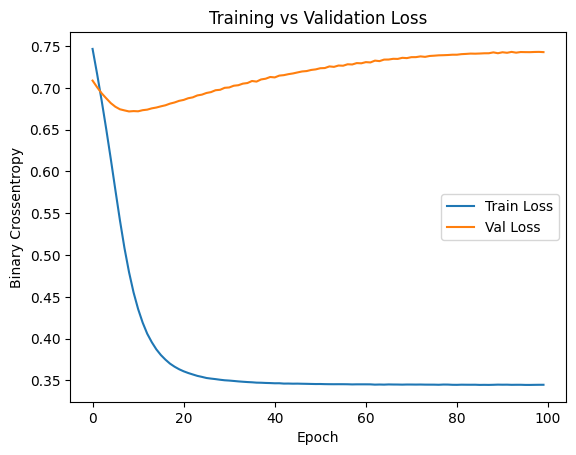

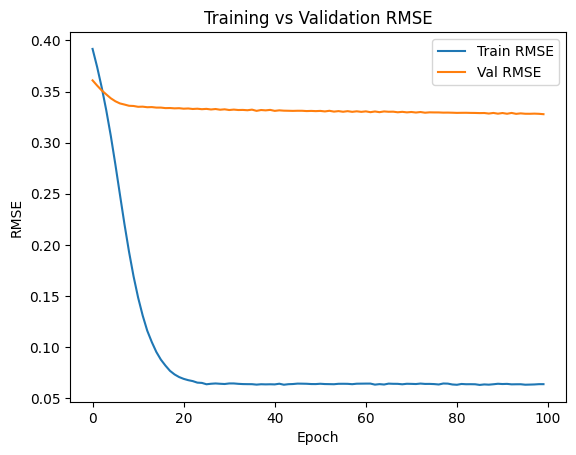

In [128]:
metrics = history.history           # dict {'loss', 'val_loss', 'rmse', 'val_rmse', ...}

# ── Loss (Binary-Crossentropy) ──
plt.figure()
plt.plot(metrics['loss'],     label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# ── RMSE ──
plt.figure()
plt.plot(metrics['rmse'],     label='Train RMSE')
plt.plot(metrics['val_rmse'], label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.show()

Perhatikanlah, proses training model cukup smooth dan model konvergen pada epochs sekitar 100. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.0636 dan error pada data validasi sebesar 0.3278. Nilai tersebut cukup bagus untuk sistem rekomendasi. Mari kita cek, apakah model ini bisa membuat rekomendasi dengan baik?

In [135]:
# --------------------------------------------------
# ➤ 0. SETTINGS
# --------------------------------------------------
TOP_N = 10          # banyak rekomendasi yang ingin ditampilkan
TOP_K = 5           # banyak produk favorit user yang ingin di‐list

# --------------------------------------------------
# ➤ 1. PILIH 1 USER (bisa random atau ditentukan manual)
# --------------------------------------------------
user_id = df['customer_id'].sample(1).iloc[0]             # random
# user_id = '…'  # ← kalau mau fix

user_name = (
    df.loc[df['customer_id'] == user_id, 'full_name']
      .dropna()
      .unique()
)
user_name = user_name[0] if len(user_name) else user_id[:8]  # fallback

print(f"Showing recommendations for user: {user_name}")
print('=' * 30)

# --------------------------------------------------
# ➤ 2. PRODUK YANG SUDAH DIRATING USER
# --------------------------------------------------
visited_mask  = df['customer_id'] == user_id
visited_df    = df[visited_mask]

# list (encoded) semua produk yang belum dikunjungi
all_items_enc    = set(product_to_product_encoded.values())
visited_items_enc = set(visited_df['product'].unique())
not_visited_enc   = list(all_items_enc - visited_items_enc)

# array [user_enc, product_enc, interaction_score=0] untuk produk yang belum dikunjungi
user_enc = user_to_user_encoded[user_id]
user_notvisit_arr = np.hstack([
    np.full((len(not_visited_enc), 1), user_enc, dtype=np.int32),
    np.array(not_visited_enc, dtype=np.int32).reshape(-1, 1),
    np.zeros((len(not_visited_enc), 1), dtype=np.float32)      # interaction = 0
])

# --------------------------------------------------
# ➤ 3. PREDIKSI & AMBIL TOP-N
# --------------------------------------------------
ratings_pred = model.predict(user_notvisit_arr, verbose=0).flatten()

top_idx          = ratings_pred.argsort()[-TOP_N:][::-1]
recommended_enc  = [not_visited_enc[i] for i in top_idx]
recommended_prod = [product_encoded_to_product[i] for i in recommended_enc]

# --------------------------------------------------
# ➤ 4. TAMPILKAN PRODUK YANG TELAH DIRATING USER (maks 10)
# --------------------------------------------------
print('Produk yang telah dirating oleh user')
print('-' * 30)

rated_user_items = (
    visited_df.sort_values(by='rating', ascending=False)
              .head(10)
)

for row in rated_user_items.itertuples():
    prod_name = row.product_name
    cat = row.product_category
    score = row.rating
    print(f"• {prod_name} ({cat}) — rating: {score}")

# --------------------------------------------------
# ➤ 5. TAMPILKAN TOP-N REKOMENDASI
# --------------------------------------------------
print('-' * 30)
print(f'Top {TOP_N} product recommendations')
print('-' * 30)

for rank, prod_name in enumerate(recommended_prod, 1):
    cat = df.loc[df['product_name'] == prod_name, 'product_category'].iloc[0]
    print(f"{rank}. {prod_name}  ({cat})")

Showing recommendations for user: Tara Mejia
Produk yang telah dirating oleh user
------------------------------
• Throw Pillows (Home Decor) — rating: 5.0
------------------------------
Top 10 product recommendations
------------------------------
1. Table Lamp  (Home Decor)
2. Sofa  (Furniture)
3. Dishwasher  (Kitchen Appliances)
4. Dell XPS 15  (Laptops)
5. Amazon Echo  (Smart Home Devices)
6. Bed Frame  (Furniture)
7. iPhone 13  (Smartphones)
8. Samsung Galaxy S22  (Smartphones)
9. Microwave Oven  (Kitchen Appliances)
10. Google Pixel 6  (Smartphones)
